In [6]:
import lightgbm as lgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
import random
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsRegressor

from sktime.split.temporal_train_test_split import temporal_train_test_split
from sktime.utils.plotting import plot_series
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.compose import make_reduction

In [29]:
dir_ = 'D:/M5 Forecasting Replication/'

In [7]:
cal_fp = './data/calendar.csv'
# sale_tr_fp = 'D:/datasets/sales_train_evaluation.csv'
sale_trv_fp = './data/sales_train_validation.csv'
sell_fp = './data/sell_prices.csv'

# ste = pd.read_csv(sale_tr_fp)
stv = pd.read_csv(sale_trv_fp)
cal = pd.read_csv(cal_fp)
sp = pd.read_csv(sell_fp)

In [8]:
# pip install sktime[all_extras]

In [9]:
def reduce_memory_usage(df, category = False):
    """ iterate through all columns of a dataframe and modify the datatype
        to reduce memory usage
    """
    start_mem = df.memory_usage().sum() / 1024 ** 2
    print("The memory usage of dataframe is {:.2f} MB".format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            if category:
                df[col] = df[col].astype('category')
    end_mem = df.memory_usage().sum() / 1024 ** 2
    print("Memory usage after optimization is: {:.2f} MB".format(end_mem))
    print("Decreased by {:.1f}%".format(100 * (start_mem - end_mem) / start_mem))

    return df

sp = reduce_memory_usage(sp)
# ste = reduce_memory_usage(ste)
stv = reduce_memory_usage(stv)
cal = reduce_memory_usage(cal)


The memory usage of dataframe is 208.77 MB
Memory usage after optimization is: 130.48 MB
Decreased by 37.5%
The memory usage of dataframe is 446.40 MB
Memory usage after optimization is: 95.00 MB
Decreased by 78.7%
The memory usage of dataframe is 0.21 MB
Memory usage after optimization is: 0.12 MB
Decreased by 41.9%


In [10]:
# print(stv[:12196]) # 12196 data for 4 stores of CA 
# print(stv[:6096]) # 6096 data for 2 stores of CA 

In [34]:
sp['price_max'] = sp.groupby(['store_id','item_id'])['sell_price'].transform('max')
sp['price_min'] = sp.groupby(['store_id','item_id'])['sell_price'].transform('min')
sp['price_std'] = sp.groupby(['store_id','item_id'])['sell_price'].transform('std')
sp['price_mean'] = sp.groupby(['store_id','item_id'])['sell_price'].transform('mean')
sp['price_norm'] = sp['sell_price']/sp['price_max']

In [35]:
def create_series_data(df, cal, sp, include_events = False):
    # melt
    df = df[:6096]
    
    df1 = pd.melt(df, id_vars=['id','item_id','dept_id','cat_id','store_id','state_id',],
                 var_name = 'day',value_name = 'sales').dropna()
    
    # add calender info
    
    df2 = df1.merge(cal, left_on = 'day', right_on = 'd',how = 'left')
    
    #select useful columns
    if include_events:
        df3 = df2[['id','item_id','dept_id','cat_id','store_id','state_id','day','sales','date','wm_yr_wk','event_name_1','event_name_2','event_type_1','event_type_2']]
    else:
        df3 = df2[['id','item_id','dept_id','cat_id','store_id','state_id','day','sales','date','wm_yr_wk']]
        
    df4 = df3.merge(sp, on = ['store_id','item_id','wm_yr_wk'], how = 'left')
    
    return df4

In [36]:
val_data_without_events = create_series_data(stv,cal,sp, False)
# val_data_with_events = create_series_data(stv,cal,sp, True)
# eval_data_without_events = create_series_data(ste,cal,sp, False)
# eval_data_with_events = create_series_data(ste,cal,sp, True)

In [37]:
val_data_without_events['date'] = pd.DatetimeIndex(val_data_without_events['date'])

In [38]:
store_data = val_data_without_events.groupby(['store_id'])['sales'].sum().reset_index()
dept_data =val_data_without_events.groupby(['dept_id'])['sales'].sum().reset_index() 
cat_data = val_data_without_events.groupby(['cat_id'])['sales'].sum().reset_index()

<Axes: xlabel='cat_id'>

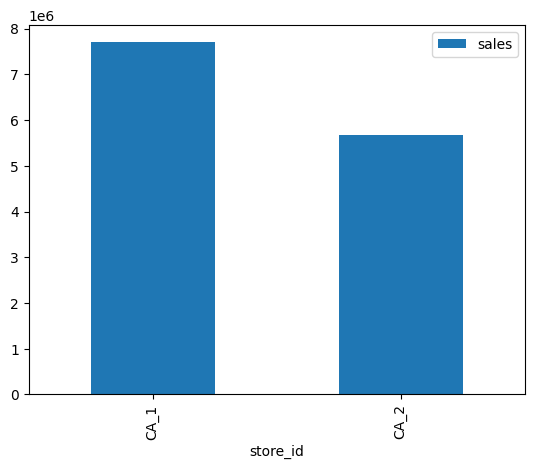

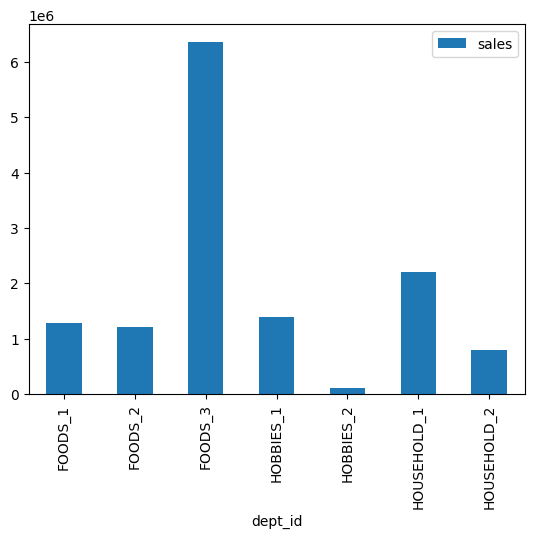

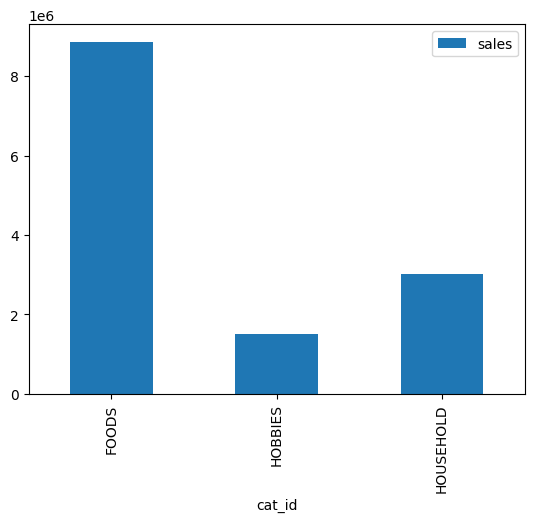

In [39]:
store_data.set_index('store_id').plot(kind='bar')
dept_data.set_index('dept_id').plot(kind='bar')
cat_data.set_index('cat_id').plot(kind='bar')

In [40]:
temp = val_data_without_events.groupby(['date','item_id'])['sales'].sum().reset_index()

In [41]:
temp.set_index('date')

,item_id,sales
date,,
2011-01-29,FOODS_1_001,5
2011-01-29,FOODS_1_002,2
2011-01-29,FOODS_1_003,8
2011-01-29,FOODS_1_004,0
2011-01-29,FOODS_1_005,11
...,...,...
2016-04-24,HOUSEHOLD_2_512,0
2016-04-24,HOUSEHOLD_2_513,5
2016-04-24,HOUSEHOLD_2_514,0


In [42]:
foods_3 = temp[temp['item_id'].str.startswith("FOODS_3")]
# item FOODS_03_090 has the highest sales 
foods_03_090 = foods_3[foods_3['item_id'] == "FOODS_3_090"].reset_index().drop(['index','item_id'],axis = 1)
foods_03_090 = foods_03_090[foods_03_090['date'] > '2016-01-01']
foods_03_090.set_index('date', inplace = True)
foods_03_090

,sales
date,
2016-01-02,0
2016-01-03,0
2016-01-04,0
2016-01-05,0
2016-01-06,0
...,...
2016-04-20,69
2016-04-21,77
2016-04-22,178


(<Figure size 1600x400 with 1 Axes>, <Axes: >)

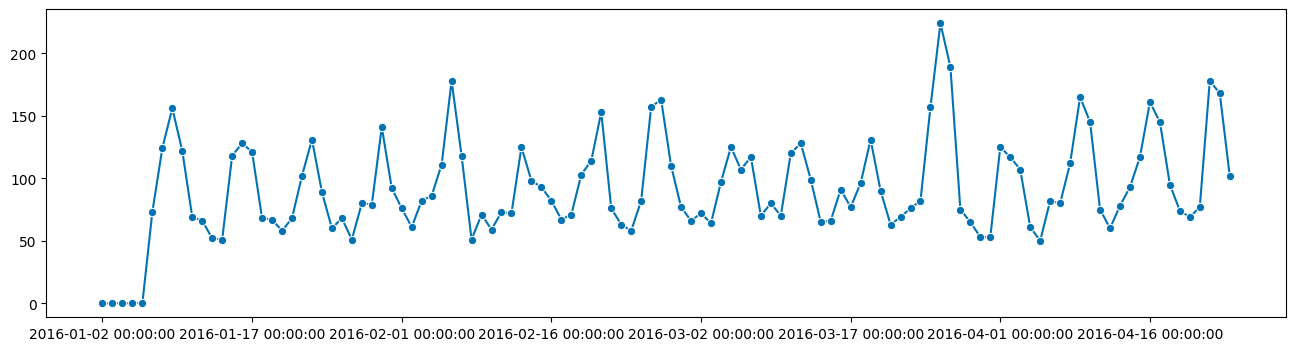

In [43]:
plot_series(foods_03_090)

(<Figure size 1600x400 with 1 Axes>, <Axes: >)

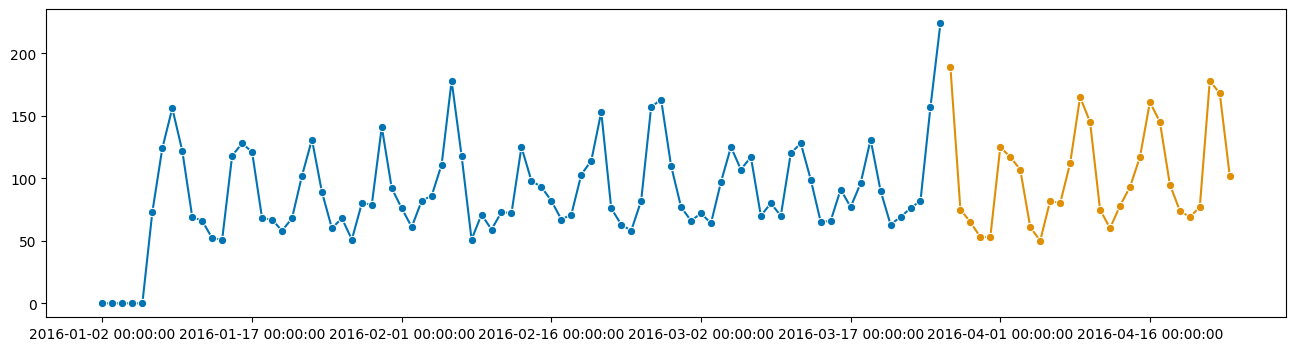

In [44]:
y_train, y_test = temporal_train_test_split(foods_03_090)
plot_series(y_train, y_test)

In [45]:
fh = range(1,30)

regressor = KNeighborsRegressor(n_neighbors=2)
forecaster = make_reduction(regressor, window_length=12, strategy="recursive")

forecaster.fit(y_train, fh= fh)

RecursiveTabularRegressionForecaster(estimator=KNeighborsRegressor(n_neighbors=2),
                                     window_length=12)

In [46]:
y_pred = forecaster.predict()

(<Figure size 1600x400 with 1 Axes>, <Axes: >)

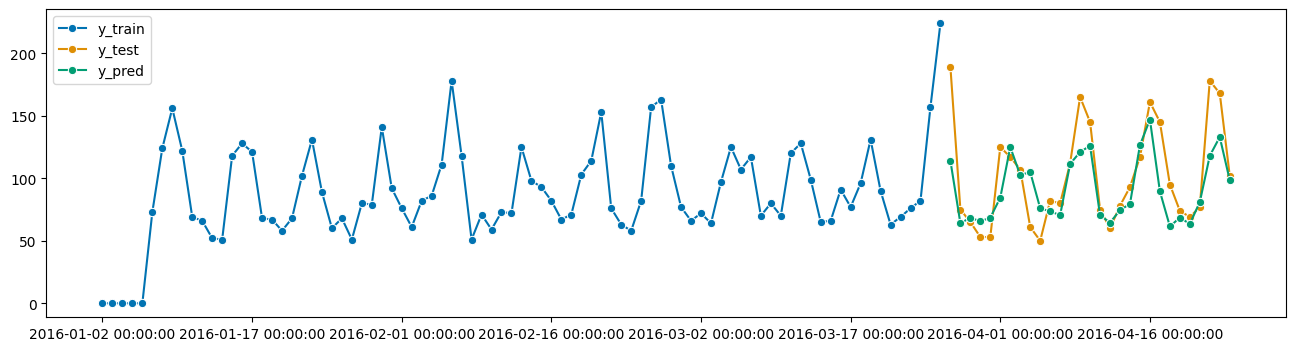

In [47]:
plot_series(y_train, y_test, y_pred, labels=['y_train', 'y_test', 'y_pred'])


In [48]:
def forecast_series(item_id):
    series_data = temp[temp['item_id'] == item_id].reset_index().drop(['index', 'item_id'], axis=1)
    series_data = series_data[series_data['date'] > '2016-01-01']
    series_data.set_index('date', inplace=True)
    
    y = series_data['sales']
    y_train, y_test = temporal_train_test_split(y, test_size=30)
    fh = ForecastingHorizon(y_test.index, is_relative=False)
    
    forecaster.fit(y_train, fh=fh)
    y_pred = forecaster.predict()
    
    mse = mean_squared_error(y_test, y_pred)
    print(f'Item: {item_id} - Mean Squared Error: {mse}')
    plot_series(y_train, y_test, y_pred, labels=["Train", "Test", "Predicted"])

Item: FOODS_3_001 - Mean Squared Error: 4.05
Item: FOODS_3_002 - Mean Squared Error: 0.0
Item: FOODS_3_003 - Mean Squared Error: 1.7333333333333334


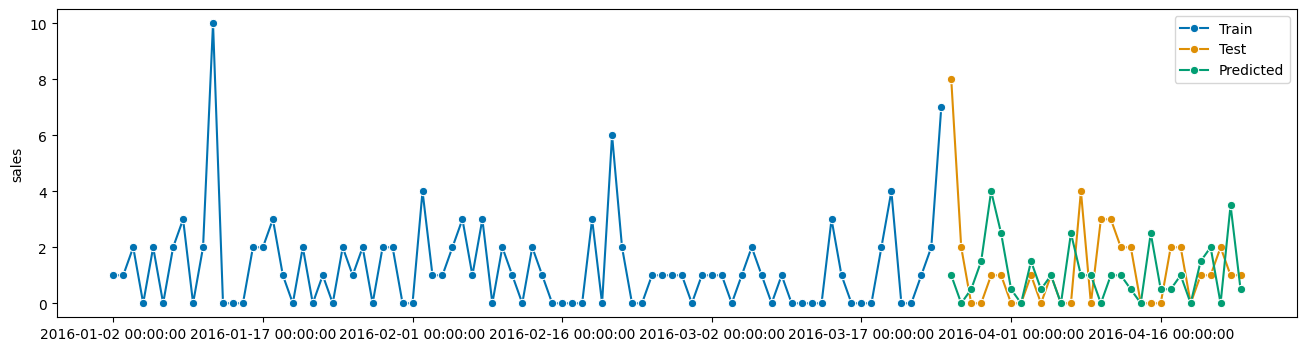

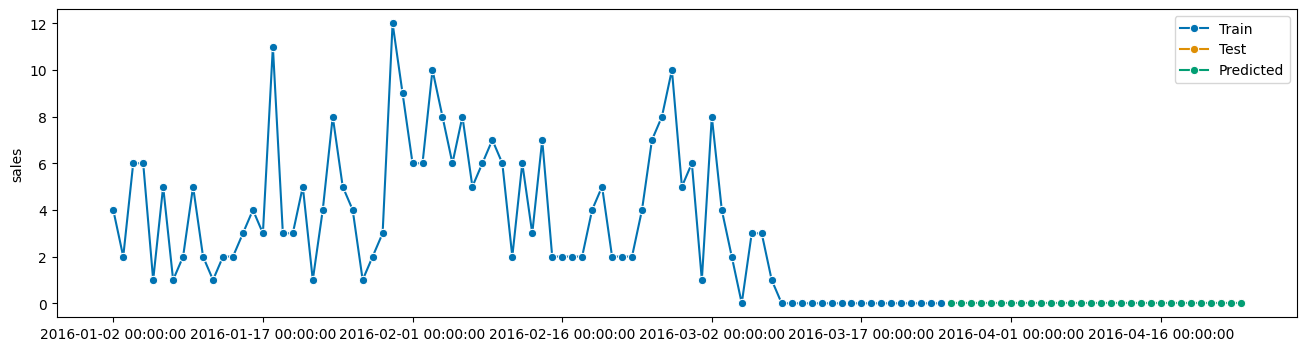

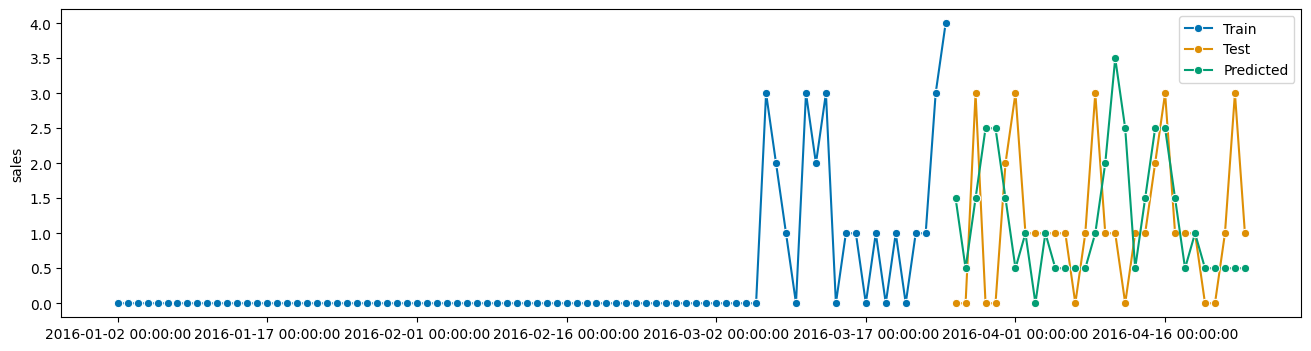

In [49]:
sample_items = foods_3['item_id'].unique()[:3]
for item in sample_items:
    forecast_series(item)

In [50]:
def forecast_series_with_multiple_forecasters(item_id, forecasters, window_length=12, test_size=30):
    series_data = temp[temp['item_id'] == item_id].reset_index().drop(['index', 'item_id'], axis=1)
    series_data = series_data[series_data['date'] > '2016-01-01']
    series_data.set_index('date', inplace=True)
    
    y = series_data['sales']
    y_train, y_test = temporal_train_test_split(y, test_size=test_size)
    fh = ForecastingHorizon(y_test.index, is_relative=False)
    
    results = {}
    for name, forecaster in forecasters.items():
        forecaster.fit(y_train, fh=fh)
        y_pred = forecaster.predict()
        mse = mean_squared_error(y_test, y_pred)
        results[name] = mse
        print(f'Item: {item_id} - Forecaster: {name} - Mean Squared Error: {mse}')
        plot_series(y_train, y_test, y_pred, labels=["Train", "Test", f"Predicted - {name}"])
    
    return results

# Function to randomly select a subset of hierarchical time series from a given department and forecast them
def forecast_random_subset_from_dept(dept_id, num_samples, forecasters=None, window_length=12, test_size=30):
    dept_data = val_data_without_events[val_data_without_events['dept_id'] == dept_id]
    items = dept_data['item_id'].unique()
    random_items = random.sample(list(items), num_samples)
    
    if forecasters is None:
        forecasters = {
            "KNeighborsRegressor": make_reduction(KNeighborsRegressor(n_neighbors=2), window_length=window_length, strategy="recursive"),
            # "LightGBM": make_reduction(lgb.LGBMRegressor(), window_length=10, strategy="recursive"),
        }
    
    all_results = {}
    for item in random_items:
        results = forecast_series_with_multiple_forecasters(item, forecasters, window_length, test_size)
        all_results[item] = results
    
    return all_results



Item: HOUSEHOLD_1_450 - Forecaster: KNeighborsRegressor - Mean Squared Error: 5.383333333333334
Item: HOUSEHOLD_1_405 - Forecaster: KNeighborsRegressor - Mean Squared Error: 6.291666666666667


{'HOUSEHOLD_1_450': {'KNeighborsRegressor': 5.383333333333334},
 'HOUSEHOLD_1_405': {'KNeighborsRegressor': 6.291666666666667}}

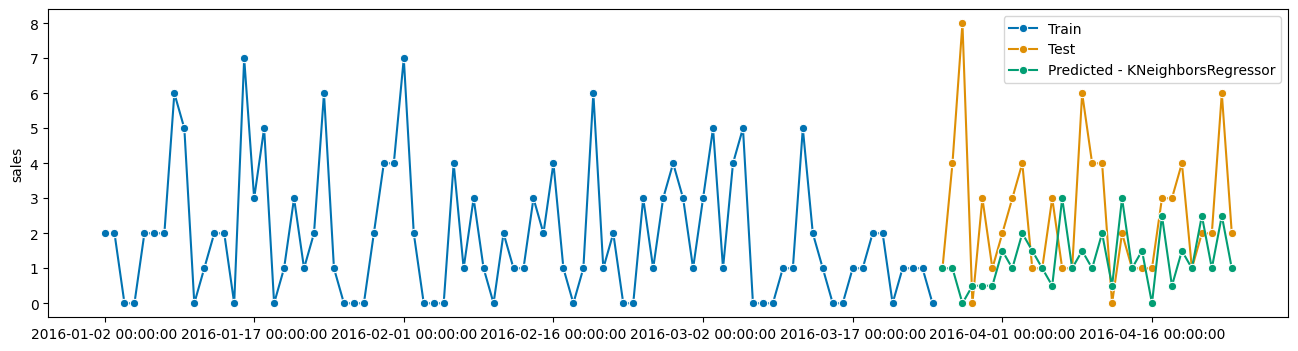

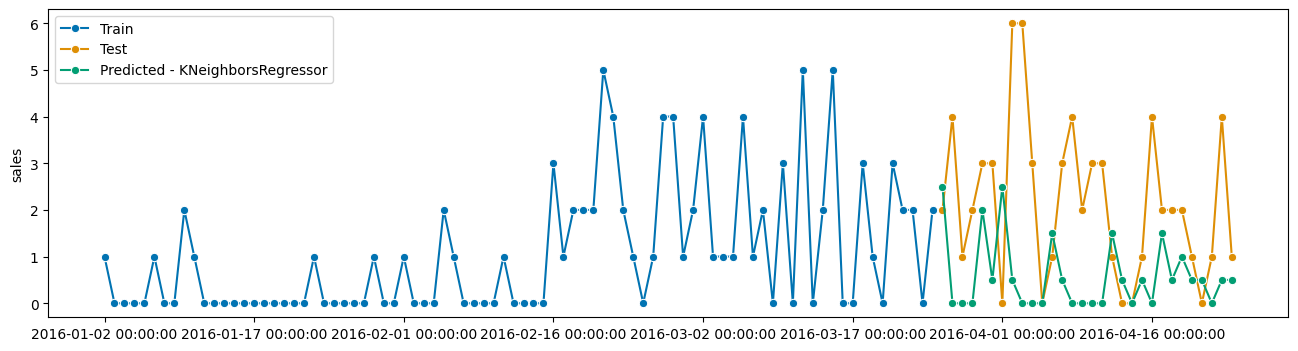

In [51]:
# Ensure temp is created from the entire dataset 
# temp = val_data_without_events.groupby(['date', 'item_id'])['sales'].sum().reset_index()

forecast_random_subset_from_dept('HOUSEHOLD_1', num_samples=2)